# SHAP

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

import torch
from torchvision import models

from captum.attr import KernelShap

# Helper functions
import sys
sys.path.append('../')

from utils.visualise import display_imagenet_output
from utils.datasets import preprocess_imagenet_image

## Load image and model

In [2]:
# Download example image
import sys
sys.path.append('../')

from utils.download import save_image

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Strix_nebulosa_CT.jpg"
save_image(url, "owl.png",)

(-0.5, 223.5, 223.5, -0.5)

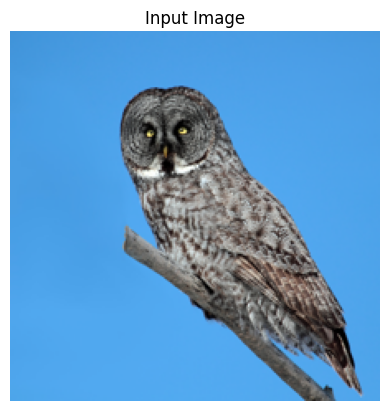

In [3]:
# Load a sample image
img_path = "owl.png"
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

In [4]:
# Load the pre-trained model (e.g., efficientnet_b0)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Set the model to gpu
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [5]:
# Preprocess the image
img_tensor = preprocess_imagenet_image(img_path)
img_tensor = img_tensor.to(device)

with torch.no_grad():
    predictions = model(img_tensor)

# Decode the output
display_imagenet_output(predictions,n=5)

great grey owl 0.8799794912338257
hummingbird 0.003089666133746505
ruddy turnstone 0.002072593430057168
kite 0.0014120083069428802
red-backed sandpiper 0.0012613605940714478


tensor(24, device='mps:0')

Figure saved to /Users/conorosullivan/Documents/XAI/shap_superpixels.pdf


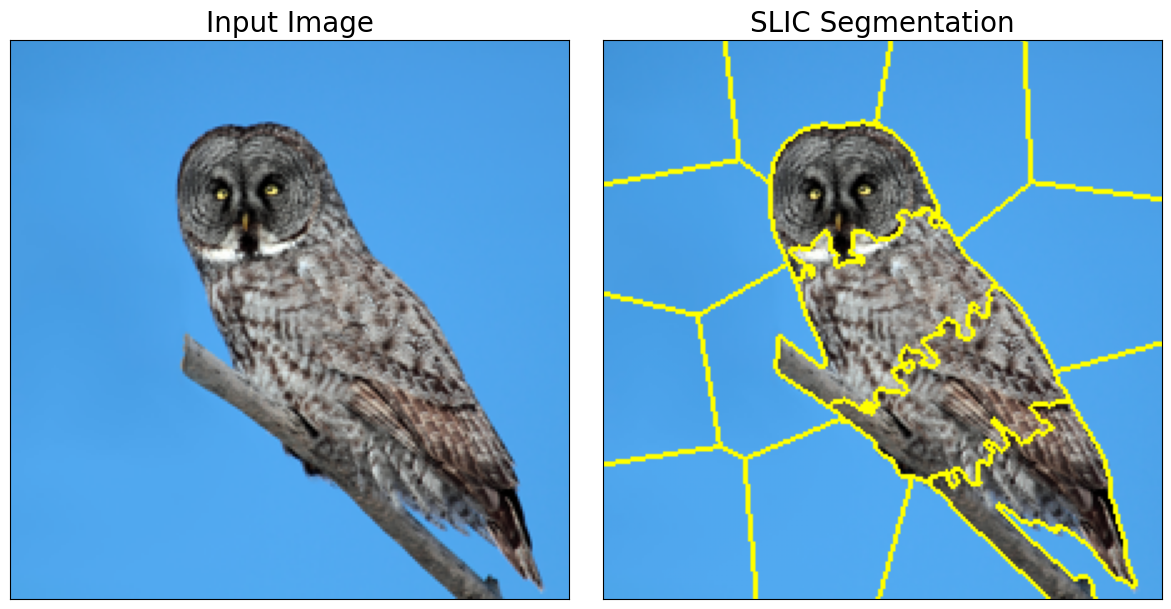

In [6]:
# Apply SLIC superpixel segmentation
img = np.array(img)
segments = slic(img, n_segments=20, compactness=30,sigma=1)

# Visualize the segmentation results
boudaries = mark_boundaries(img, segments)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title("Input Image")
ax[1].imshow(boudaries)
ax[1].set_title("SLIC Segmentation")

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## KernelSHAP Attribution

In [7]:
# Get the predicted class index
target_class = predictions.argmax().item()
print(f"Predicted class index: {target_class}")

# Format segments for LIME
feature_mask = torch.from_numpy(segments).unsqueeze(0).to(device)

Predicted class index: 24


In [8]:
ks = KernelShap(model)

attr = ks.attribute(img_tensor,
                       target=target_class,
                       feature_mask=feature_mask,
                       n_samples= 1000,
                       perturbations_per_eval = 100,
                       show_progress=True)

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/kernel_shap.py:275: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  feature_mask, num_interp_features = construct_feature_mask(


Kernel Shap attribution:   0%|          | 0/10 [00:00<?, ?it/s]

Figure saved to /Users/conorosullivan/Documents/XAI/shap_attribution.pdf


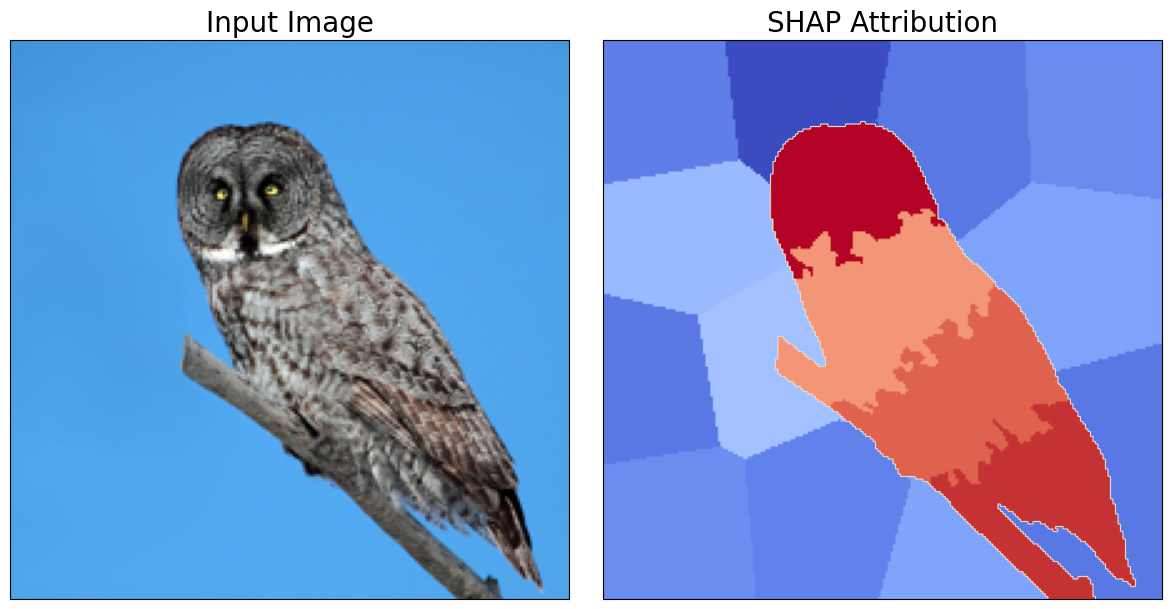

In [9]:
# Process attribution
processed_attr = attr.detach().cpu().numpy()[0]
processed_attr = np.mean(processed_attr,axis=0) # Average across channels
processed_attr = processed_attr - np.min(processed_attr) # Scale to [0,1]
processed_attr = processed_attr/np.max(processed_attr)

# Visualise attribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title("Input Image")

ax[1].imshow(processed_attr, cmap = 'coolwarm')
ax[1].set_title("SHAP Attribution")


for a in ax:
    a.set_xticks([])
    a.set_yticks([])

In [10]:
# We will compare all feature masks and attributions for later
feature_masks = {"large_superpixels":boudaries}
attributions = {"large_superpixels":processed_attr}

## Alternative feature masks

In [11]:
# No feature mask
ks = KernelShap(model)
attr = ks.attribute(img_tensor,
                       target=target_class,
                       n_samples= 1000,
                       perturbations_per_eval = 100,
                       show_progress=True)

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/lime.py:1141: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  warnings.warn(


Kernel Shap attribution:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
# Process attribution
processed_attr = attr.detach().cpu().numpy()[0]
processed_attr = np.mean(processed_attr,axis=0) # Average across channels
processed_attr = processed_attr - np.min(processed_attr) # Scale to [0,1]
processed_attr = processed_attr/np.max(processed_attr)

# Save feature mask and attribution to lists
feature_masks['pixel-wise'] = img
attributions['pixel-wise'] = processed_attr

In [13]:
# Regular square superpixels
n = 8
k = 224 // n  # 28

segments = np.arange(k * k).reshape(k, k).repeat(n, axis=0).repeat(n, axis=1)

# Format segments for SHAP
feature_mask = torch.from_numpy(segments).unsqueeze(0).to(device)

In [14]:
ks = KernelShap(model)
attr = ks.attribute(img_tensor,
                       target=target_class,
                       feature_mask=feature_mask,
                       n_samples= 1000,
                       perturbations_per_eval = 100,
                       show_progress=True)

# Process attribution
processed_attr = attr.detach().cpu().numpy()[0]
processed_attr = np.mean(processed_attr,axis=0) # Average across channels
processed_attr = processed_attr - np.min(processed_attr) # Scale to [0,1]
processed_attr = processed_attr/np.max(processed_attr)


# Add feature mask and attribution to lists
boudaries = mark_boundaries(img, segments)
feature_masks['regular_superpixels'] = boudaries
attributions['regular_superpixels'] = processed_attr

Kernel Shap attribution:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
# Smaller SLIC superpixels
img = np.array(img)
segments = slic(img, n_segments=100, compactness=30,sigma=1)
feature_mask = torch.from_numpy(segments).unsqueeze(0).to(device)

In [16]:
ks = KernelShap(model)
attr = ks.attribute(img_tensor,
                       target=target_class,
                       feature_mask=feature_mask,
                       n_samples= 1000,
                       perturbations_per_eval = 100,
                       show_progress=True)

# Process attribution
processed_attr = attr.detach().cpu().numpy()[0]
processed_attr = np.mean(processed_attr,axis=0) # Average across channels
processed_attr = processed_attr - np.min(processed_attr) # Scale to [0,1]
processed_attr = processed_attr/np.max(processed_attr)

# Add feature mask and attribution to lists
boudaries = mark_boundaries(img, segments)
feature_masks['small_superpixels'] = boudaries
attributions['small_superpixels'] = processed_attr

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/kernel_shap.py:275: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  feature_mask, num_interp_features = construct_feature_mask(


Kernel Shap attribution:   0%|          | 0/10 [00:00<?, ?it/s]

Figure saved to /Users/conorosullivan/Documents/XAI/shap_feature_masks_comparison.pdf


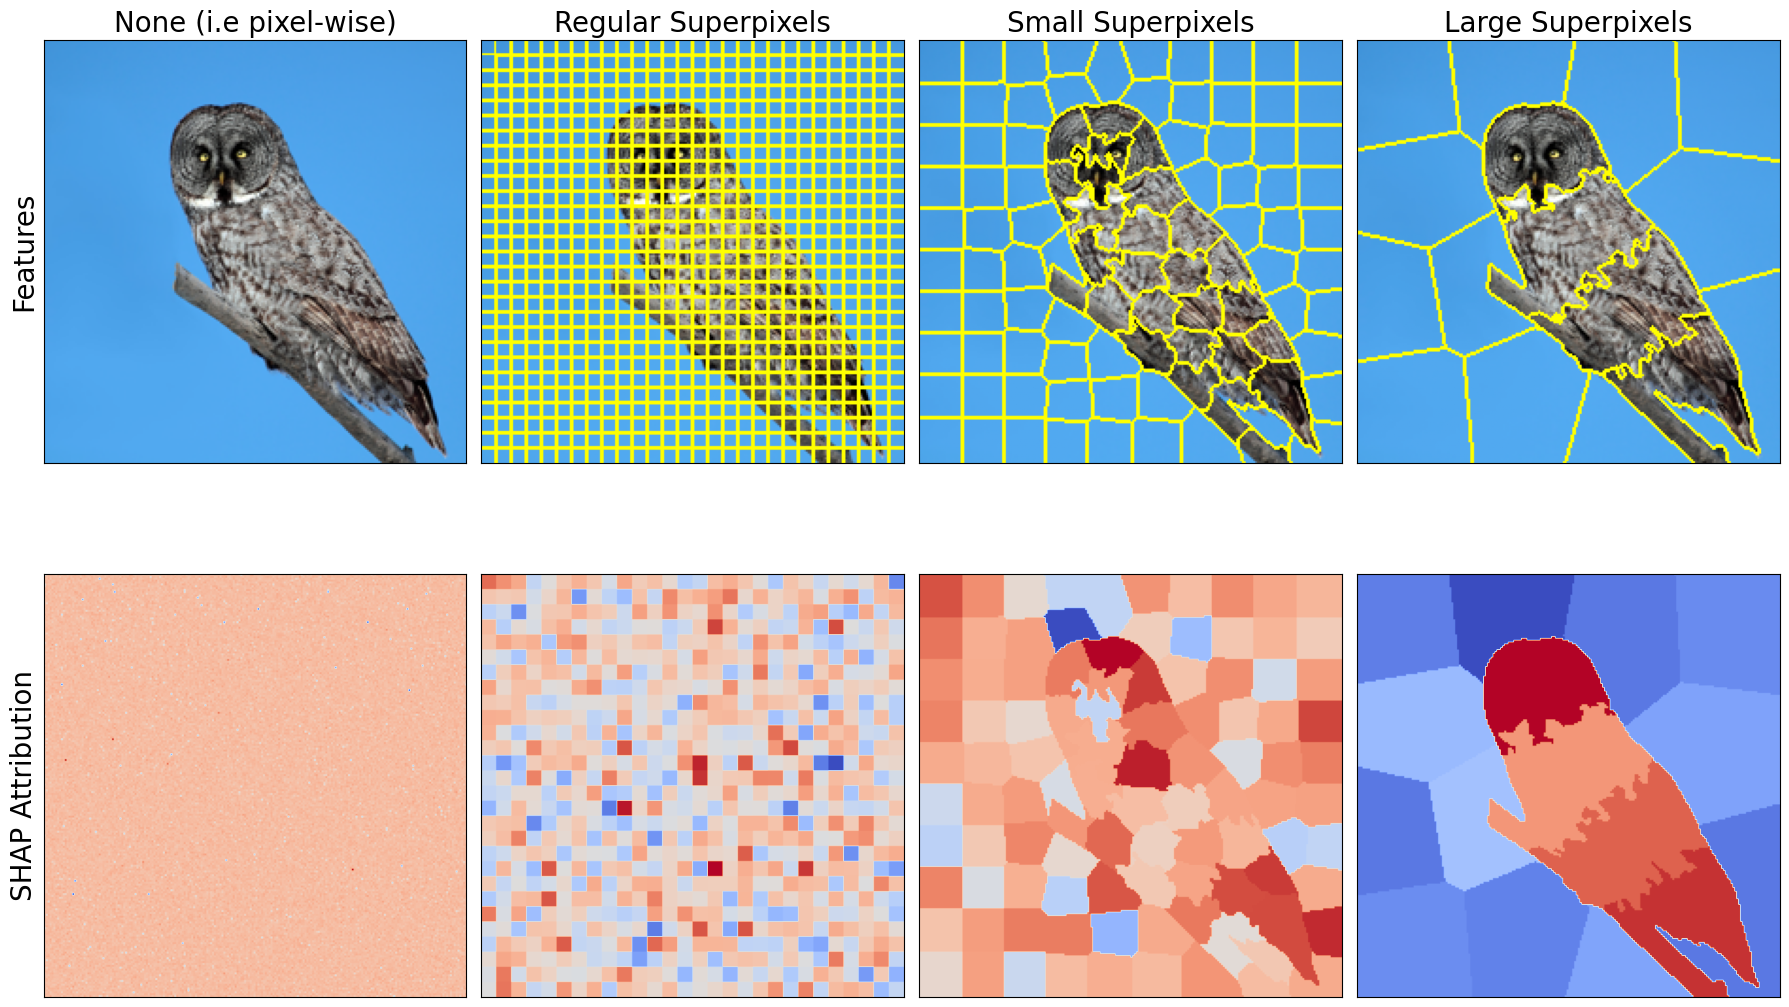

In [17]:
# Visualise all feature masks and attributions
fig, ax = plt.subplots(2,4, figsize=(18, 12))

# Show segments
ax[0,0].imshow(feature_masks['pixel-wise'])
ax[0,0].set_title("None (i.e pixel-wise)")

ax[0,1].imshow(feature_masks['regular_superpixels'])
ax[0,1].set_title("Regular Superpixels")

ax[0,2].imshow(feature_masks['small_superpixels'])
ax[0,2].set_title("Small Superpixels")

ax[0,3].imshow(feature_masks['large_superpixels'])
ax[0,3].set_title("Large Superpixels")


# Show attributions
ax[1,0].imshow(attributions['pixel-wise'], cmap = 'coolwarm')
ax[1,1].imshow(attributions['regular_superpixels'], cmap = 'coolwarm')
ax[1,2].imshow(attributions['small_superpixels'], cmap = 'coolwarm')
ax[1,3].imshow(attributions['large_superpixels'], cmap = 'coolwarm')

ax[0,0].set_ylabel("Features", fontsize=20)
ax[1,0].set_ylabel("SHAP Attribution", fontsize=20)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# Addtional Figures

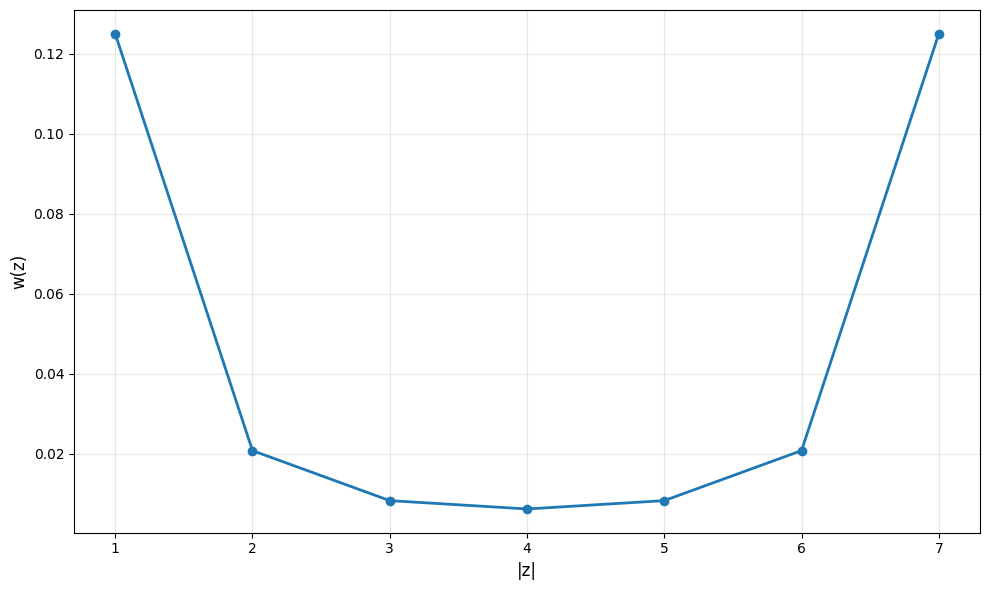

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, factorial

def shap_kernel(z, M):
    """
    Calculate the SHAP kernel weight for coalition size z.

    Parameters:
    z: coalition size (number of features present)
    M: total number of features

    Returns:
    weight according to SHAP kernel
    """
    if z == 0 or z == M:
        return np.inf

    weight = (M - 1) / (comb(M, z) * z * (M - z))
    return weight


def shap_kernel_2(z, M):
    """
    Alternative SHAP kernel weight calculation using the formula:
    w(z) = (M - 1) / (comb(M, z) * z * (M - z))

    Parameters:
    z: coalition size (number of features present)
    M: total number of features

    Returns:
    weight according to SHAP kernel
    """
    if z == 0 or z == M:
        return np.inf

    weight = (M - 1) * factorial(z -1) * factorial ( M - z -1) / factorial(M)
    return weight

def plot_shap_kernel(M):
    """
    Plot the SHAP kernel weights for different coalition sizes.

    Parameters:
    M: total number of features
    """
    # Coalition sizes from 1 to M-1 (excluding 0 and M which give infinity)
    z_values = np.arange(1, M)
    weights = [shap_kernel_2(z, M) for z in z_values]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(z_values, weights, '-', linewidth=2, marker='o', markersize=6)
    plt.xlabel('|z|', fontsize=12)
    plt.ylabel('w(z)', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
M = 8  # Total number of features
plot_shap_kernel(M)

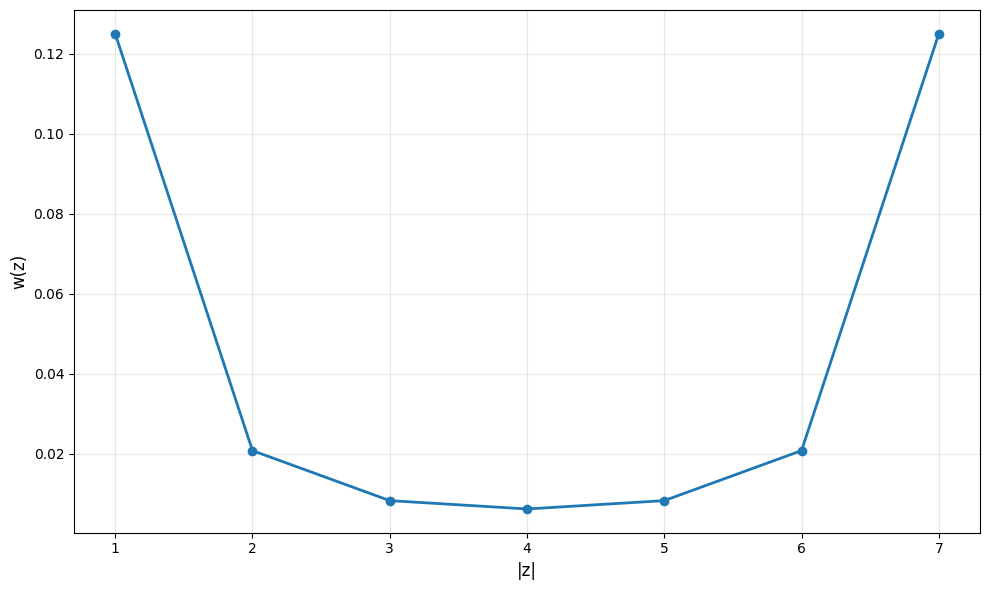

<Figure size 640x480 with 0 Axes>

In [19]:
plot_shap_kernel(M)

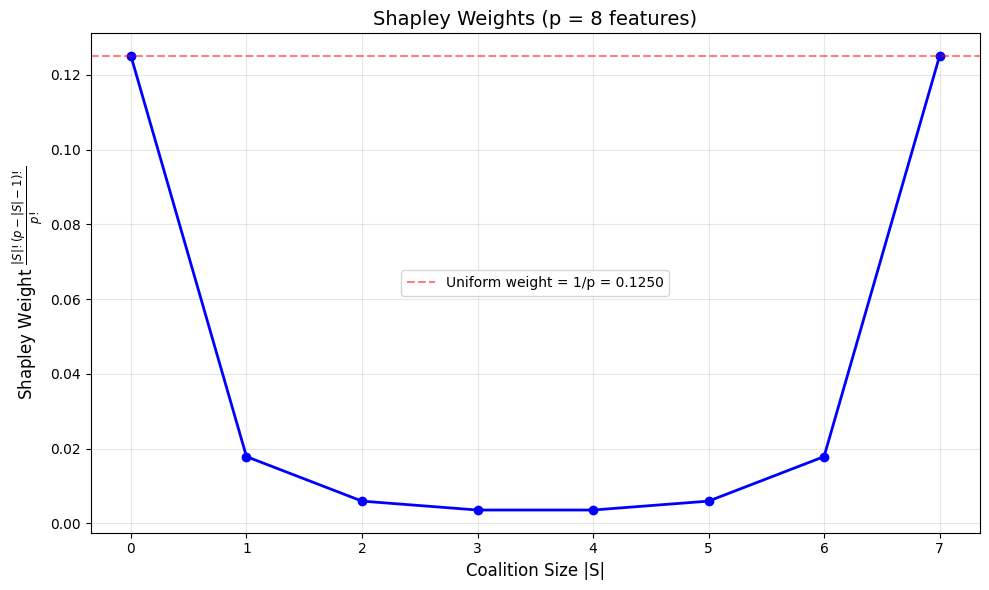

Sum of all weights: 0.304762 (should be 1.0)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

def shapley_weight(S, p):
    """
    Calculate the Shapley weight for coalition size S.

    Parameters:
    S: coalition size (number of features in the coalition, excluding feature i)
    p: total number of features

    Returns:
    weight according to Shapley formula
    """
    weight = (factorial(S) * factorial(p - S - 1)) / factorial(p)
    return weight

def plot_shapley_weight(p):
    """
    Plot the Shapley weights for different coalition sizes.

    Parameters:
    p: total number of features
    """
    # Coalition sizes from 0 to p-1 (S excludes feature i, so max is p-1)
    S_values = np.arange(0, p)
    weights = [shapley_weight(S, p) for S in S_values]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(S_values, weights, 'b-', linewidth=2, marker='o', markersize=6)
    plt.xlabel('Coalition Size |S|', fontsize=12)
    plt.ylabel(r'Shapley Weight $\frac{|S|!(p-|S|-1)!}{p!}$', fontsize=12)
    plt.title(f'Shapley Weights (p = {p} features)', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add horizontal line showing uniform distribution for comparison
    uniform_weight = 1/p
    plt.axhline(y=uniform_weight, color='r', linestyle='--', alpha=0.5,
                label=f'Uniform weight = 1/p = {uniform_weight:.4f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print the sum of weights to verify it equals 1
    print(f"Sum of all weights: {sum(weights):.6f} (should be 1.0)")

# Example usage
p = 8  # Total number of features
plot_shapley_weight(p)